In [1]:
import tensorflow as tf

print(tf.__version__)
for device in tf.config.list_physical_devices():
    print(device)

2.7.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [3]:
g_loss_metrics = tf.metrics.Mean(name='g_loss')
d_loss_metrics = tf.metrics.Mean(name='d_loss')
total_loss_metrics = tf.metrics.Mean(name='total_loss')

In [4]:
# hyper parameters
# ITRATION = 10000
EPOCHS = 100
Z_DIM = 100
BATCH_SIZE = 128
BUFFER_SIZE = 60000
D_LR = 0.0004
G_LR = 0.0004
IMAGE_SHAPE = (28, 28, 1)
# RANDOM_SEED = 42

In [5]:
# np.random.seed(RANDOM_SEED)
# tf.random.seed(RANDOM_SEED)

In [6]:
def get_random_z(batch_size, z_dim):
    return  tf.random.uniform([batch_size, z_dim], minval=-1, maxval=1)

In [7]:
def make_discriminator(input_shape):
    return tf.keras.Sequential([

        layers.Conv2D(64, 5, strides=2, padding='same',
        input_shape=input_shape),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])

In [8]:
def make_generator(input_shape):
    return tf.keras.Sequential([

        layers.Dense(7*7*256, use_bias=False, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7,256)),

        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False),
        layers.Activation('tanh')

    ])

In [9]:
def get_loss_fn():

    criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def d_loss_fn(real_logits, fake_logits):

        real_loss = criterion(tf.ones_like(real_logits), real_logits)
        fake_loss = criterion(tf.zeros_like(fake_logits), fake_logits)
        
        return real_loss + fake_loss
    
    def g_loss_fn(fake_logits):
        return criterion(tf.ones_like(fake_logits), fake_logits)

    return d_loss_fn, g_loss_fn

In [10]:
(train_x, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [11]:
print(train_x.shape)

(60000, 28, 28)


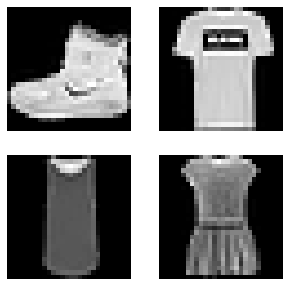

In [12]:
items = train_x[:4]

fig = plt.figure(figsize=(5, 5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(items[i,:,:], cmap='gray')
    plt.axis('off')

In [13]:
60000 / 128

468.75

In [14]:
train_x = train_x.reshape(-1, 28, 28, 1)
train_x = (train_x - 127.5) / 127.5
train_ds = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
)

In [15]:
G = make_generator((Z_DIM,))
D = make_discriminator(IMAGE_SHAPE)

g_optim = tf.keras.optimizers.Adam(G_LR, beta_1=0.5)
d_optim = tf.keras.optimizers.Adam(D_LR, beta_1=0.5)

d_loss_fn, g_loss_fn = get_loss_fn()

In [16]:
@tf.function()
def train_step(real_images):

    z = get_random_z(BATCH_SIZE, Z_DIM)
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:

        fake_images = G(z, training=True)

        fake_logits = D(fake_images, training=True)
        real_logits = D(real_images, training=True)

        d_loss = d_loss_fn(real_logits, fake_logits)
        g_loss = g_loss_fn(fake_logits)

    d_gradients = d_tape.gradient(d_loss, D.trainable_variables)
    g_gradients = g_tape.gradient(g_loss, G.trainable_variables)

    d_optim.apply_gradients(zip(d_gradients, D.trainable_variables))
    g_optim.apply_gradients(zip(g_gradients, G.trainable_variables))

    return d_loss, g_loss

In [17]:
# 60000 // 128

In [18]:
# training loop
D_losses = list()
G_losses = list()

def train(dataset, epochs=EPOCHS):

    print("start training..")

    for epoch in range(epochs):
        for iteration, real_images in enumerate(dataset):

            d_loss, g_loss = train_step(real_images)

            if iteration % 20 == 0:
                D_losses.append(d_loss)
                G_losses.append(g_loss)

 
        display.clear_output(wait=True)
        print(f'At end of epoch:{epoch}, D-loss={d_loss} | G-loss={g_loss}')
        generate_and_save_images(G, epoch + 1)
        
    display.clear_output(wait=True)
    print(f'At end of epoch:{epoch}, D-loss={d_loss} | G-loss={g_loss}')
    generate_and_save_images(G, epoch + 1)  

In [19]:
def generate_and_save_images(generator, epoch, ):

  z = get_random_z(16, Z_DIM)
  predictions = generator(z, training=False)

  fig = plt.figure(figsize=(12, 12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('fakeimage_fashionmnist/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

At end of epoch:99, D-loss=1.337051272392273 | G-loss=0.8186303377151489


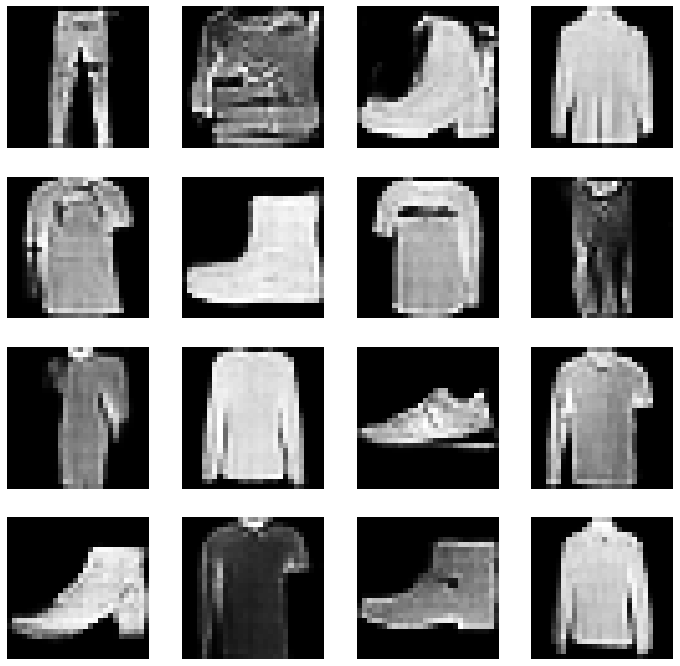

In [20]:
if __name__ == "__main__":
    train(train_ds)

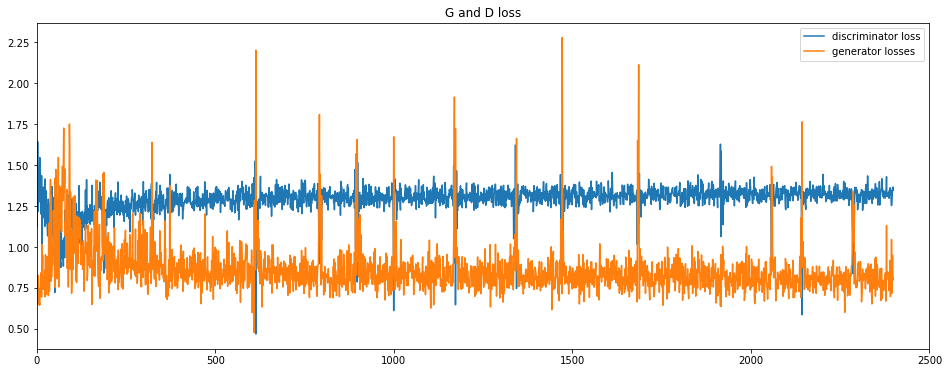

In [21]:
fig = plt.figure(figsize=(16, 6))
plt.plot(D_losses, label='discriminator loss')
plt.plot(G_losses, label='generator losses')
plt.title("G and D loss")
plt.legend()
plt.xlim((0, 2500))
plt.show()